<a href="https://colab.research.google.com/github/gremlin97/RacialBiasDetectionAndMitigationCSE598/blob/main/FinalRacialBiasDetectionAndMitigationCSE598.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Preprocessing

In [1]:
# Importing the required libraries

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pandas as pd
import os
from pycocotools.coco import COCO
import torch
from torch.utils.data import TensorDataset, DataLoader
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# Setting env variable to display CUDA Errors on Colab  
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# Mounting google drive for persistent access to dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Acquired the demographic annotations/skin tones into a dataframe
!unzip /content/drive/MyDrive/COCO2014ValDemographicAnnotations-20221202T083559Z-001.zip
df = pd.read_csv('/content/COCO2014ValDemographicAnnotations/images_val2014.csv')

Archive:  /content/drive/MyDrive/COCO2014ValDemographicAnnotations-20221202T083559Z-001.zip
  inflating: COCO2014ValDemographicAnnotations/README.pdf  
  inflating: COCO2014ValDemographicAnnotations/images_val2014.csv  
  inflating: COCO2014ValDemographicAnnotations/instances_2014all.csv  


In [5]:
# Sampling the dataset. We see skin color per bounding box, dataset split 
# and bb_skin that assigns skin color to largest person supercategory object in the image i.e largest bounding box
df.sample(10)

,id,skin,ratio,bb_skin,bb_gender,split
914,37513,['Light'],[0.18093089788732394],Light,Female,train
1607,67975,['Light'],[0.11455729166666667],Light,Male,train
14221,133244,"['Light', 'Unsure']","[0.110970705, 0.322110028]",Unsure,Unsure,val
5462,230360,['Dark'],[0.41981118266978923],Dark,Male,train
3731,157960,"['Light', 'Light']","[0.11921223958333334, 0.04701497395833333]",Light,Male,train
2260,96615,"['Light', 'Light']","[0.2539943391866913, 0.1531076709796673]",Light,Male,train
1619,68546,"['Light', 'Light', 'Light', 'Light']","[0.2429491370292887, 0.12102183577405858, 0.11...",Light,Male,train
6435,273470,['Light'],[0.04162109375],Light,Female,train
4016,170181,"['Light', nan, nan]","[0.08163259857319834, 0.11217640651031655, 0.1...",NaN,Female,train
7957,335774,['Unsure'],[0.038575444560669456],Unsure,Unsure,train


In [6]:
# Describing the dataset stats
df.describe()

,id
count,15762.000000
mean,291073.385103
std,167921.637049
min,136.000000
25%,147033.250000
50%,292421.500000
75%,437198.750000
max,581886.000000


In [7]:
# We sample images from the train split
df_f = df[df['split'] == 'train']
df_f.sample(20)

,id,skin,ratio,bb_skin,bb_gender,split
311,12827,['Light'],[0.3077880859375],Light,Female,train
10151,429807,['Light'],[0.07177734375],Light,Female,train
13340,562803,"['Light', 'Light']","[0.03355794270833334, 0.133828125]",Light,Male,train
13612,574404,"['Light', 'Light', 'Light', 'Light']","[0.0542510986328125, 0.06553955078125, 0.19104...",Light,Male,train
2490,106228,"['Light', 'Dark']","[0.08536367866004962, 0.06108095533498759]",Both,NaN,train
2779,117471,['Light'],[0.3497914227166276],Light,Female,train
5966,252629,"['Unsure', 'Unsure']","[0.07353629976580796, 0.060286153395784546]",Unsure,Unsure,train
4309,183895,"['Unsure', 'Unsure']","[0.031175130208333332, 0.02119140625]",Unsure,Unsure,train
5114,214503,['Light'],[0.062128],Light,Male,train
2257,96530,[nan],[0.03668122270742358],NaN,Male,train


In [8]:
# Obtaining and storing the image ids and tones
id = df_f['id'] 
tone = df_f['bb_skin']

In [9]:
!unzip -q '/content/drive/MyDrive/annotations_trainval2017 (2).zip'

In [10]:
#Loaded the COCO Anotations using pycocotools
coco = COCO('/content/annotations/instances_train2017.json')

loading annotations into memory...
Done (t=14.87s)
creating index...
index created!


### Data Exploration and Visualization of the Annotations




In [11]:
# Sampling random image ids
imgIds=sorted(coco.getImgIds())
imgId = imgIds[np.random.randint(100)]

In [12]:
# Length of ids
len(imgIds)

118287

In [13]:
# Type of ids
type(imgIds)

list

In [14]:
# Exploring one particular image id
imgIds[1]

25

In [15]:
imgId = imgIds[1]

In [16]:
# Loaded particualar annotation
img = coco.loadImgs(imgId)

In [17]:
# Displaying Specific Annotation
img

[{'license': 1,
  'file_name': '000000000025.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000000025.jpg',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-16 14:11:30',
  'flickr_url': 'http://farm1.staticflickr.com/94/241612385_d9e5b891ed_z.jpg',
  'id': 25}]

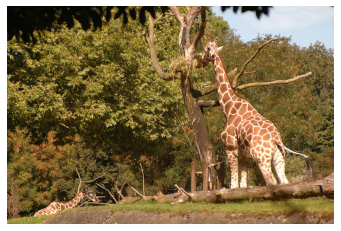

In [18]:
#Reading and displaying the image from the specific annotation file
I = io.imread(img[0]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [19]:
# Obtaining and printing the category id
id_c = img[0]['id']
category_ids = coco.getCatIds()
print(category_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


In [20]:
# Some exploration of the Category IDs.
coco_annotation = coco
cat_ids = coco_annotation.getCatIds()
print(f"Number of Unique Categories: {len(cat_ids)}")
print("Category IDs:")
print(cat_ids)  # The IDs are not necessarily consecutive.

# All categories.
cats = coco_annotation.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

# Category ID -> Category Name.
query_id = cat_ids[23]
query_annotation = coco_annotation.loadCats([query_id])[0]
query_name = query_annotation["name"]
query_supercategory = query_annotation["supercategory"]
print("Category ID -> Category Name:")
print(
    f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}"
)

Number of Unique Categories: 80
Category IDs:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
Categories Names:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted

In [21]:
# Creating a map of categories and their ids and displaying 10 of these items
z = zip(cat_ids,cat_names)
map = {}

for (x,y) in z:
  map[x] = y

list(map.items())[0:10]

[(1, 'person'),
 (2, 'bicycle'),
 (3, 'car'),
 (4, 'motorcycle'),
 (5, 'airplane'),
 (6, 'bus'),
 (7, 'train'),
 (8, 'truck'),
 (9, 'boat'),
 (10, 'traffic light')]

In [22]:
# Checking category 25
cat_names[25]

'umbrella'

In [23]:
# Displying category for a random image
annIds = coco.getAnnIds(imgIds=id_c, catIds=category_ids)
anns = coco.loadAnns(annIds)
map[anns[0]['category_id']]

'giraffe'

In [24]:
# Obtaining 1000 image ids to work with from the demographic annotations 

id_list = []

for x in id:
  id_list.append(x)

id_list = id_list[0:1000]
ann_list = id_list

print(len(id_list))

1000


In [25]:
# Loading the images from the annotation, and their corresponding coco labels 
Ydual_pred = []
img_list= []

for x in id_list:
  annIds = coco.getAnnIds(imgIds=x, catIds=category_ids)
  anns = coco.loadAnns(annIds)
  Ydual_pred.append(anns[0]['category_id'])
  img = coco.loadImgs(x)
  I = io.imread(img[0]['coco_url'])
  img_list.append(I)

In [26]:
# Obtaining the Data Distribution of COCO Labels in our subset
ano_dis = []

for x in id_list:
  annIds = coco.getAnnIds(imgIds=x, catIds=category_ids)
  anns = coco.loadAnns(annIds)
  ano_dis.append(anns[0]['category_id'])

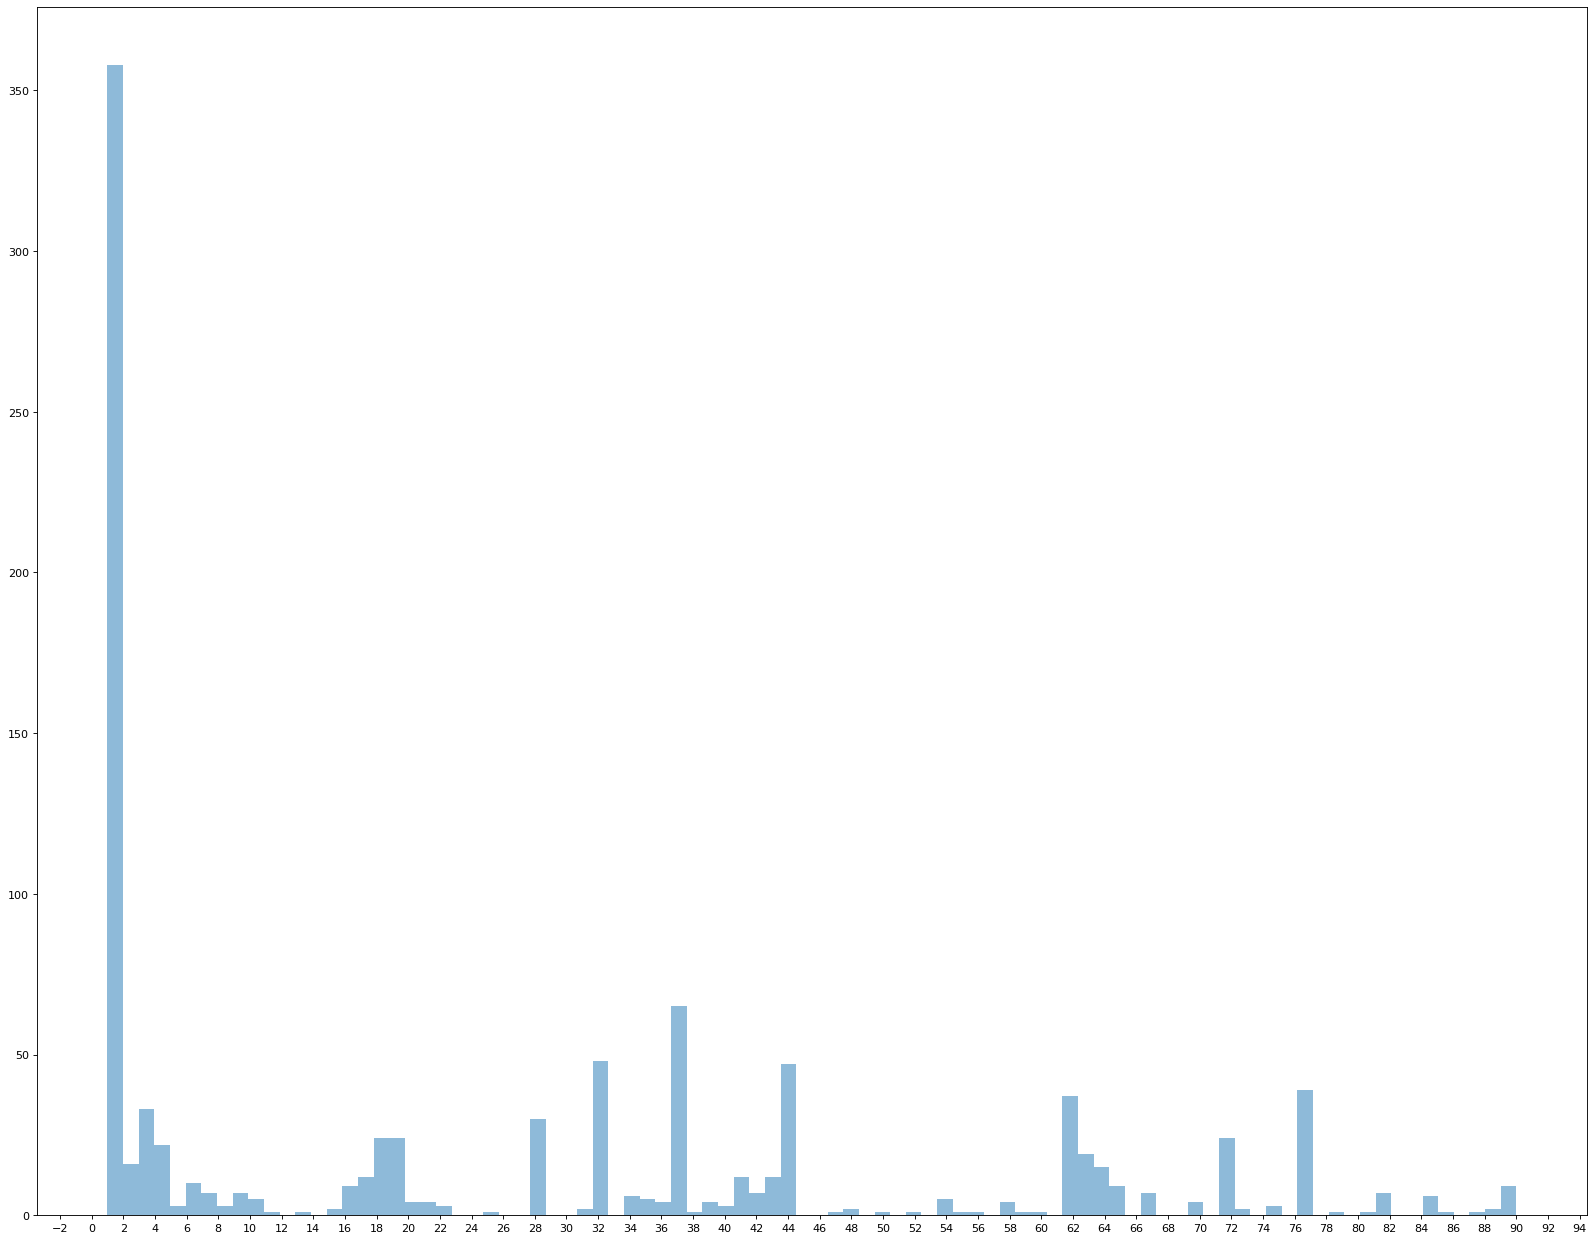

In [27]:
# Plotting the histogram of this distribution, we observe that 35% of the datapoints are with a single label
# hence we use the most prominent label for prediction

from matplotlib import pyplot as plt
plt.figure(figsize=(25, 20), dpi=80)
plt.hist(ano_dis, bins=90, alpha=0.5)
plt.locator_params(axis='x', nbins=90)

In [28]:
# Converting our image list into a np array and printing its shape
img_arr = np.array(img_list, dtype='object')
img_arr.shape 

(1000,)

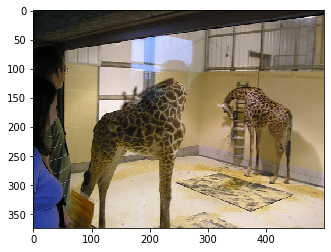

In [29]:
# Plotting the first image from the img_arr list
from matplotlib import pyplot as plt
plt.imshow(img_arr[0], interpolation='nearest')
plt.show()

In [30]:
# Checking the size of files copied to Colab
!ls -l --block-size=M

total 1M
drwxr-xr-x 2 root root 1M Dec  7 17:21 annotations
drwxr-xr-x 2 root root 1M Dec  7 17:21 COCO2014ValDemographicAnnotations
drwx------ 5 root root 1M Dec  7 17:21 drive
drwxr-xr-x 1 root root 1M Dec  5 14:37 sample_data


### Dataset Leakage

In [31]:
# Obtatining the corresponding list of skin tones for the images using the demographic annotations dataframe
y_list = []
for x in tone:
  if x=='Dark':
    y_list.append(1)
  if x=='Light':
    y_list.append(0)

In [32]:
y_arr = y_list
y_arr = y_arr[0:1000]
# Obtaining a joint list of COCO Label and skin tone label
multilabel_y = list(zip(Ydual_pred,y_arr))

In [33]:
# Creating our dataset for calculating dataset leakage by creating our train ds with ground truth annotations (poisoned + flipped) and
#  target as the skin tones/racial cues

import random

X = []
y = []

def pet(dualpreds, X, y):
  for x in dualpreds:
    temp = []
    temp.append(x[0])
    y.append(x[1])
    for i in range(5):
      temp.append(random.randint(0,79))
    X.append(temp)
  
  return X,y

dl_x, dl_y = pet(multilabel_y, X,y)

In [34]:
# Calcualting Dataset Leakage
from sklearn.linear_model import LogisticRegression
X_ = np.array(X)
y_ = np.array(y)
X_.shape, y_.shape

((1000, 6), (1000,))

In [35]:
# Some label flipping
for lb in y_:
  if np.random.randint(1,10)==5:
    if y_[0] == 1:
      y_[0] = 0
    else:
      y_[1] = 1

In [36]:
# Calculated Dataset Leakage
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.25, random_state=42)
from sklearn import svm
clf = svm.SVC(C=1000, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.808

In [37]:
###=========== The logistic regression model overfits hence we dont use it==========###

# clf = LogisticRegression(C=1000, random_state=42, max_iter=100).fit(X_train, y_train)
# clf.score(X_test, y_test)

In [38]:
# Dictionary of Images ids and skin tones labels
dictv = {}

for x,y in zip(id_list, y_list):
  dictv[x] = y


In [39]:
# Creating a new working image numpy array
img_arr_rn = img_arr
# Displaying image array
img_arr_rn[0],type(img_arr_rn)

(array([[[ 12,  16,  17],
         [  9,  13,  14],
         [ 12,  16,  17],
         ...,
         [ 24,  23,  21],
         [ 26,  25,  23],
         [ 26,  25,  23]],
 
        [[ 10,  14,  15],
         [  8,  12,  13],
         [ 12,  16,  17],
         ...,
         [ 31,  30,  25],
         [ 33,  33,  25],
         [ 34,  34,  26]],
 
        [[  9,  13,  14],
         [  8,  12,  13],
         [ 11,  15,  16],
         ...,
         [ 38,  40,  29],
         [ 39,  41,  30],
         [ 40,  42,  31]],
 
        ...,
 
        [[ 35,  54, 148],
         [ 38,  57, 151],
         [ 40,  59, 153],
         ...,
         [215, 197, 183],
         [213, 195, 181],
         [220, 202, 188]],
 
        [[ 38,  57, 152],
         [ 38,  57, 152],
         [ 37,  56, 151],
         ...,
         [214, 196, 182],
         [211, 193, 179],
         [218, 200, 186]],
 
        [[ 41,  59, 157],
         [ 41,  60, 155],
         [ 39,  58, 153],
         ...,
         [221, 203, 189],
  

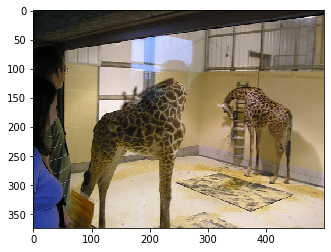

In [40]:
# Checking array validity by displaying the image
from matplotlib import pyplot as plt
plt.imshow(img_arr_rn[0], interpolation='nearest')
plt.show()

### Defining the Dataset and Dataloaders for our models below

In [91]:
# Transforms we apply to our dataset

from torchvision import transforms

tr = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
    ])

In [92]:
# Defining the dataset and dataloader for our baseline model prediciting the skin tones from images

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class SingDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.Tensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index],'RGB')
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

data = img_arr_rn
targets = y_arr
dataset = SingDataset(data, targets, transform=tr)
dataloader = DataLoader(dataset, batch_size=4)

In [93]:
# Creating the labels for the COCO Dataset
yc = np.array(Ydual_pred)
cl = []
for x in yc:
  arr = np.zeros(91) 
  arr[x-1] = 1
  cl.append(arr)

In [94]:
# Defining the dataset and dataloader for our fine-tuned resnet model that predicts the COCOC Label from the image

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class StDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.Tensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index],'RGB')
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

data_st = img_arr_rn
cl = np.array(yc)
targets_st = cl
stdataset = StDataset(data_st, targets_st, transform=tr)
stdataloader = DataLoader(stdataset, batch_size=4)

In [95]:
# Experimenting with the dataset by iterating its components and checking its length

In [96]:
len(dataset)

1000

In [97]:
next(iter(stdataset))

(tensor([[[0.0431, 0.0471, 0.0588,  ..., 0.1020, 0.1020, 0.1137],
          [0.0353, 0.0510, 0.0549,  ..., 0.1373, 0.1412, 0.1451],
          [0.0392, 0.0471, 0.0549,  ..., 0.1294, 0.1216, 0.1137],
          ...,
          [0.1451, 0.1490, 0.1529,  ..., 0.8471, 0.8431, 0.8471],
          [0.1451, 0.1490, 0.1451,  ..., 0.8471, 0.8392, 0.8431],
          [0.1569, 0.1490, 0.1529,  ..., 0.8549, 0.8510, 0.8549]],
 
         [[0.0588, 0.0627, 0.0745,  ..., 0.1020, 0.0980, 0.1098],
          [0.0510, 0.0667, 0.0706,  ..., 0.1412, 0.1451, 0.1490],
          [0.0549, 0.0627, 0.0706,  ..., 0.1294, 0.1255, 0.1176],
          ...,
          [0.2196, 0.2235, 0.2275,  ..., 0.7765, 0.7725, 0.7765],
          [0.2196, 0.2235, 0.2196,  ..., 0.7765, 0.7686, 0.7725],
          [0.2275, 0.2235, 0.2275,  ..., 0.7843, 0.7804, 0.7843]],
 
         [[0.0627, 0.0667, 0.0784,  ..., 0.0863, 0.0824, 0.0941],
          [0.0549, 0.0706, 0.0745,  ..., 0.1020, 0.1098, 0.1137],
          [0.0588, 0.0667, 0.0745,  ...,

In [98]:
# Experimentation Code

# v = [(1,2),(3,4)]
# v = torch.tensor(v)
# print(v[0])

# for x in multilabel_y:
#   if x[0]>82:
#     print(x[0])

In [99]:
# Creating the one-hot encoding for multilabel classification of skin tone and COCO Label

def encode(multilabel_y):
  res = []
  for x in multilabel_y:
    temp_arr = np.zeros(90)
    temp_arr[x[0]-1] = 1
    if(x[1]):
      temp_arr[81] = 1
    else:
      temp_arr[80] = 1
    res.append(temp_arr)

  return res

res = encode(multilabel_y) 
res = np.array(res)
print(res) 
ye = res

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [100]:
# Creating the multilabel-classification dataset and dataloader for dual prediction of skintone and COCO Label

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class MultiDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.Tensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index],'RGB')
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

data = img_arr_rn
# targets_m = multilabel_y
targets_m = ye
dataset_m = MultiDataset(data, targets_m, transform=tr)
dataloader_m = DataLoader(dataset_m, batch_size=4)

In [101]:
# Exploring the dataset and dataloader

In [102]:
next(iter(dataset_m))

(tensor([[[0.0431, 0.0471, 0.0588,  ..., 0.1020, 0.1020, 0.1137],
          [0.0353, 0.0510, 0.0549,  ..., 0.1373, 0.1412, 0.1451],
          [0.0392, 0.0471, 0.0549,  ..., 0.1294, 0.1216, 0.1137],
          ...,
          [0.1451, 0.1490, 0.1529,  ..., 0.8471, 0.8431, 0.8471],
          [0.1451, 0.1490, 0.1451,  ..., 0.8471, 0.8392, 0.8431],
          [0.1569, 0.1490, 0.1529,  ..., 0.8549, 0.8510, 0.8549]],
 
         [[0.0588, 0.0627, 0.0745,  ..., 0.1020, 0.0980, 0.1098],
          [0.0510, 0.0667, 0.0706,  ..., 0.1412, 0.1451, 0.1490],
          [0.0549, 0.0627, 0.0706,  ..., 0.1294, 0.1255, 0.1176],
          ...,
          [0.2196, 0.2235, 0.2275,  ..., 0.7765, 0.7725, 0.7765],
          [0.2196, 0.2235, 0.2196,  ..., 0.7765, 0.7686, 0.7725],
          [0.2275, 0.2235, 0.2275,  ..., 0.7843, 0.7804, 0.7843]],
 
         [[0.0627, 0.0667, 0.0784,  ..., 0.0863, 0.0824, 0.0941],
          [0.0549, 0.0706, 0.0745,  ..., 0.1020, 0.1098, 0.1137],
          [0.0588, 0.0667, 0.0745,  ...,

In [103]:
i,o = next(iter(dataset))
np.max(i.numpy())

1.0

In [104]:
c = i.numpy()
c = (c * 255).astype(np.uint8)
print(c)

[[[ 11  12  15 ...  26  26  29]
  [  9  13  14 ...  35  36  37]
  [ 10  12  14 ...  33  31  29]
  ...
  [ 37  38  39 ... 216 215 216]
  [ 37  38  37 ... 216 214 215]
  [ 40  38  39 ... 218 217 218]]

 [[ 15  16  19 ...  26  25  28]
  [ 13  17  18 ...  36  37  38]
  [ 14  16  18 ...  33  32  30]
  ...
  [ 56  57  58 ... 198 197 198]
  [ 56  57  56 ... 198 196 197]
  [ 58  57  58 ... 200 199 200]]

 [[ 16  17  20 ...  22  21  24]
  [ 14  18  19 ...  26  28  29]
  [ 15  17  19 ...  34  32  29]
  ...
  [148 150 152 ... 184 183 184]
  [150 151 149 ... 184 182 183]
  [154 151 150 ... 186 185 186]]]


In [105]:
# Defining torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [106]:
# Defining dataset size for training loop
dataset_sizes = len(dataset)
print(dataset_sizes)

1000


### Defining Train Loops and model architecture for our Initial Models

In [107]:
# Defining training loop for our skin tone prediction model
def train_model(model, criterion, optimizer, scheduler,  dataloader, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        #model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')    
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [108]:
prob = torch.tensor([0.3,0.4,0.6,0.7])
i = torch.argmax(prob)
print(i)

tensor(3)


In [129]:
# Defining training loop for our COCO Label prediction model
def train_model_st(model, criterion, optimizer, dataloader, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        #model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            outputs = model(inputs)
            # outputs = outputs.cpu()
            # print(outputs)
            # print('\n')


            pred = torch.nn.Sigmoid()(outputs)
            # pred_t = pred.cpu()
            preds = torch.argmax(pred, 1)


            # print(preds)
            # print('\n')
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            
            # running_corrects += torch.sum(preds == torch.argmax(labels.data,1))
            running_corrects += torch.sum(preds == labels.data)

            # running_corrects += torch.sum(outputs.data == labels.data)

            # print(labels)
            # print('\n')
            # print(torch.argmax(labels.data,1))
            # print('\n')
            # scheduler.step()

        epoch_loss = running_loss / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')    
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [164]:
def train_model_ml(model, criterion, optimizer, scheduler,  dataloader, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        hl = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            outputs = model(inputs)
            #_, preds = torch.max(outputs, 1)
            # print(f'Pred:{outputs}')
            # print(f'LD:{labels}')
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase

            loss.backward()
            optimizer.step()

            pred = torch.nn.Sigmoid()(outputs)
            # print("Pred is",pred)
            # print("Labels are:",labels)
            pred_t = pred.cpu()
            pred_t = (pred>0.5)
            hl+=hamming_loss(labels.cpu(), pred_t.cpu())
            

            # statistics
            running_loss += loss.item() * inputs.size(0)
            #running_corrects += torch.sum(preds.data == labels.data)
            # print(outputs,labels)
            scheduler.step()

        epoch_loss = running_loss/dataset_sizes
        # epoch_acc = running_corrects.double() / dataset_sizes
        # epoch_acc = running_corrects / dataset_sizes

        #print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}') 
        hlm = hl/dataset_sizes
        acc = (1-hlm)*100 
        print(f'Train Loss: {epoch_loss:.4f}')   
        print(f'Accuracy: {acc:.4f}')  
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [110]:
# Defining model for skin tone prediction

model_ft_n = models.resnet18(pretrained=True)
num_ftrs = model_ft_n.fc.in_features
# Here the size of each output sample is set to 2.
model_ft_n.fc = nn.Sequential(nn.Dropout(0.1),
                         nn.Linear(model_ft_n.fc.in_features, 64),
                         nn.Linear(64, 2))

model_ft_n = model_ft_n.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model_ft_n.parameters(), lr=3e-4, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [111]:
model_ft_n

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [112]:
# Defining model for COCO Label prediction

model_ft_onlyst = models.resnet18(pretrained=True)
num_ftrs = model_ft_onlyst.fc.in_features

model_ft_onlyst.fc = nn.Sequential(nn.Dropout(0.1),
                         nn.Linear(model_ft_onlyst.fc.in_features, 256),
                         nn.Linear(256,91))

# model_ft_onlyst.fc = nn.Sequential(nn.Dropout(0.1),
#                          nn.Linear(model_ft_onlyst.fc.in_features, 256),
#                          nn.Linear(256,1))

model_ft_onlyst = model_ft_onlyst.to(device)

# criterion_st = nn.MSELoss()
#criterion_st = nn.BCEWithLogitsLoss()
criterion_st = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_st = torch.optim.Adam(model_ft_onlyst.parameters(), lr=3e-4)
# optimizer_st = torch.optim.SGD(model_ft_onlyst.parameters(), lr=3e-4, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler_st = lr_scheduler.StepLR(optimizer_st, step_size=7, gamma=0.1)

In [113]:
model_ft_mn = models.resnet18(pretrained=True)

model_ft_mn.fc = nn.Sequential(nn.Dropout(0.1),
                         nn.Linear(model_ft_mn.fc.in_features, 256),
                         nn.Linear(256, 90))

model_ft_mn = model_ft_mn.to(device)  

criterion_m = nn.BCEWithLogitsLoss()

optimizer_ftm = torch.optim.Adam(model_ft_mn.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_m = lr_scheduler.StepLR(optimizer_ftm, step_size=7, gamma=0.1)

In [114]:
model_ft_mn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Experimenting with one-hot encoding Hamming Distance and model inputs and outputs

In [115]:
m = map
mil = list(m.items())
mapL = []
for x in mil:
  tempL = []
  tl = list(x)
  tempL.append(tl[1])
  tempL.append(tl[0])
  mapL.append(tempL)

In [116]:
sml_list = []
for x in list(m.values()):
  sml_tmp = []
  sml_tmp.append(x)
  sml_list.append(sml_tmp)

In [117]:
from sklearn.preprocessing import OneHotEncoder
enc_exp = OneHotEncoder(handle_unknown='ignore')
enc_exp.fit(mapL)
enc_exp.transform([['person', 1]]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [118]:
sml_list[0]

['person']

In [119]:
from sklearn.preprocessing import OneHotEncoder
sml_arr = np.asarray(sml_list)
enc = OneHotEncoder(sparse=False)
onehot = enc.fit_transform(sml_list)
print(enc.transform([['person']]))
print(enc.inverse_transform([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
[['person']]


In [120]:
# example of a one hot encoding
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
# define data
data = asarray([['red'], ['green'], ['blue']])
print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(data)
print(onehot)

[['red']
 ['green']
 ['blue']]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [121]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(mapL)
enc.transform([['person', 1], ['motorcycle', 4]]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [122]:
out = model_ft_mn(torch.rand(4,3,224,224).to(device))

In [123]:
torch.max(out.data,1)

torch.return_types.max(
values=tensor([0.8343, 0.9028, 0.7037, 0.6982], device='cuda:0'),
indices=tensor([35, 35, 38, 33], device='cuda:0'))

In [124]:
torch.max(out,1)

torch.return_types.max(
values=tensor([0.8343, 0.9028, 0.7037, 0.6982], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([35, 35, 38, 33], device='cuda:0'))

In [165]:
model_ft_n.fc[2]

Linear(in_features=64, out_features=2, bias=True)

In [166]:
# Experimenting with hamming loss metric from sklearn
from sklearn.metrics import hamming_loss
prob = torch.tensor([0.3,0.4,0.6,0.7])
out = (prob>0.5).float()
label = torch.tensor([0,0,1,1])
(1-hamming_loss(label, out))*100

100.0

## Training Intial Models

In [174]:
# Training our Skin tone prediction model
model_ft_n = train_model(model_ft_n, criterion, optimizer, exp_lr_scheduler, dataloader, num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.7417 Acc: 0.3910

Epoch 1/9
----------
Train Loss: 0.7374 Acc: 0.3870

Epoch 2/9
----------
Train Loss: 0.7368 Acc: 0.4000

Epoch 3/9
----------
Train Loss: 0.7415 Acc: 0.3840

Epoch 4/9
----------
Train Loss: 0.7373 Acc: 0.3860

Epoch 5/9
----------
Train Loss: 0.7324 Acc: 0.4130

Epoch 6/9
----------
Train Loss: 0.7363 Acc: 0.3950

Epoch 7/9
----------
Train Loss: 0.7400 Acc: 0.3800

Epoch 8/9
----------
Train Loss: 0.7402 Acc: 0.3850

Epoch 9/9
----------
Train Loss: 0.7357 Acc: 0.4180



In [130]:
# Cheking input and output dimension for my COCO Label prediction model
for inputs, labels in stdataloader:
  print(inputs,labels)
  break
# i,l = next(iter(stdataset))
# print(torch.min(i),l)

tensor([[[[0.0431, 0.0471, 0.0588,  ..., 0.1020, 0.1020, 0.1137],
          [0.0353, 0.0510, 0.0549,  ..., 0.1373, 0.1412, 0.1451],
          [0.0392, 0.0471, 0.0549,  ..., 0.1294, 0.1216, 0.1137],
          ...,
          [0.1451, 0.1490, 0.1529,  ..., 0.8471, 0.8431, 0.8471],
          [0.1451, 0.1490, 0.1451,  ..., 0.8471, 0.8392, 0.8431],
          [0.1569, 0.1490, 0.1529,  ..., 0.8549, 0.8510, 0.8549]],

         [[0.0588, 0.0627, 0.0745,  ..., 0.1020, 0.0980, 0.1098],
          [0.0510, 0.0667, 0.0706,  ..., 0.1412, 0.1451, 0.1490],
          [0.0549, 0.0627, 0.0706,  ..., 0.1294, 0.1255, 0.1176],
          ...,
          [0.2196, 0.2235, 0.2275,  ..., 0.7765, 0.7725, 0.7765],
          [0.2196, 0.2235, 0.2196,  ..., 0.7765, 0.7686, 0.7725],
          [0.2275, 0.2235, 0.2275,  ..., 0.7843, 0.7804, 0.7843]],

         [[0.0627, 0.0667, 0.0784,  ..., 0.0863, 0.0824, 0.0941],
          [0.0549, 0.0706, 0.0745,  ..., 0.1020, 0.1098, 0.1137],
          [0.0588, 0.0667, 0.0745,  ..., 0

In [170]:
# Training our COCO Label prediction model
model_ft_st = train_model_st(model_ft_onlyst, criterion_st, optimizer_st, stdataloader, num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.7742 Acc: 0.7870

Epoch 1/9
----------
Train Loss: 0.8524 Acc: 0.7570

Epoch 2/9
----------
Train Loss: 0.1197 Acc: 0.9660

Epoch 3/9
----------
Train Loss: 0.0484 Acc: 0.9920

Epoch 4/9
----------
Train Loss: 0.0188 Acc: 0.9970

Epoch 5/9
----------
Train Loss: 0.0087 Acc: 0.9990

Epoch 6/9
----------
Train Loss: 0.0056 Acc: 0.9990

Epoch 7/9
----------
Train Loss: 0.0022 Acc: 1.0000

Epoch 8/9
----------
Train Loss: 0.0016 Acc: 1.0000

Epoch 9/9
----------
Train Loss: 0.0013 Acc: 1.0000



In [132]:
# Checking the full connected layer in the model
model_ft_st.fc

Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): Linear(in_features=256, out_features=91, bias=True)
)

In [167]:
next(iter(dataloader_m))

[tensor([[[[0.0431, 0.0471, 0.0588,  ..., 0.1020, 0.1020, 0.1137],
           [0.0353, 0.0510, 0.0549,  ..., 0.1373, 0.1412, 0.1451],
           [0.0392, 0.0471, 0.0549,  ..., 0.1294, 0.1216, 0.1137],
           ...,
           [0.1451, 0.1490, 0.1529,  ..., 0.8471, 0.8431, 0.8471],
           [0.1451, 0.1490, 0.1451,  ..., 0.8471, 0.8392, 0.8431],
           [0.1569, 0.1490, 0.1529,  ..., 0.8549, 0.8510, 0.8549]],
 
          [[0.0588, 0.0627, 0.0745,  ..., 0.1020, 0.0980, 0.1098],
           [0.0510, 0.0667, 0.0706,  ..., 0.1412, 0.1451, 0.1490],
           [0.0549, 0.0627, 0.0706,  ..., 0.1294, 0.1255, 0.1176],
           ...,
           [0.2196, 0.2235, 0.2275,  ..., 0.7765, 0.7725, 0.7765],
           [0.2196, 0.2235, 0.2196,  ..., 0.7765, 0.7686, 0.7725],
           [0.2275, 0.2235, 0.2275,  ..., 0.7843, 0.7804, 0.7843]],
 
          [[0.0627, 0.0667, 0.0784,  ..., 0.0863, 0.0824, 0.0941],
           [0.0549, 0.0706, 0.0745,  ..., 0.1020, 0.1098, 0.1137],
           [0.0588, 0.06

In [168]:
#Checking and displaying our dataloader
for xb, yb in dataloader_m:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([4, 3, 224, 224])
torch.Size([4, 90])


In [169]:
# Training our dual prediction model
model_ft_mn = train_model_ml(model_ft_mn, criterion_m, optimizer_ftm, exp_lr_scheduler_m, dataloader_m, num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.3277
Accuracy: 99.0142

Epoch 1/9
----------
Train Loss: 0.3203
Accuracy: 99.1658

Epoch 2/9
----------
Train Loss: 0.3205
Accuracy: 99.1625

Epoch 3/9
----------
Train Loss: 0.3204
Accuracy: 99.1722

Epoch 4/9
----------
Train Loss: 0.3203
Accuracy: 99.1586

Epoch 5/9
----------
Train Loss: 0.3205
Accuracy: 99.1653

Epoch 6/9
----------
Train Loss: 0.3206
Accuracy: 99.1528

Epoch 7/9
----------
Train Loss: 0.3207
Accuracy: 99.1722

Epoch 8/9
----------
Train Loss: 0.3203
Accuracy: 99.1600

Epoch 9/9
----------
Train Loss: 0.3204
Accuracy: 99.1569



### Obtaining logits for Model Leakage

In [133]:
# Using PyTorch hooks to extract activations/outputs from any required layer of the neural network 
# Through one forward pass

# Extracting logits from the penultimate layer of our COCO labels prediction model and storing it in a dictionary which we will use
# to predict skin tones/racial cues from using an attacker model

activation_onlyst = {}

dataloader_modelleakage_st = DataLoader(stdataset, batch_size=64)

def get_activation_st(name):
    def hook(model, input, output):
        #print(model)
        activation_onlyst[name] = output.detach()
    return hook


modelst = model_ft_st

modelst = modelst.to(device)
modelst.fc[1].register_forward_hook(get_activation_st('mf1st'))

xst = next(iter(dataloader_modelleakage_st))
xst = xst[0]
xst = xst.to(device)
st_y = xst[1]
output_st = modelst(xst)
print(output_st)

tensor([[ 0.8526,  0.9018,  0.0506,  ...,  0.1437,  0.4645,  0.2580],
        [-0.2021, -0.1134, -0.5112,  ...,  0.0719, -0.5342, -0.0341],
        [-0.3640,  0.2511, -0.7453,  ...,  0.3490, -0.2414, -0.2444],
        ...,
        [-0.0885,  0.1459, -0.0280,  ...,  0.5642, -0.1732, -0.3173],
        [ 0.0535,  0.6787, -0.1940,  ...,  0.2005,  0.0095,  0.0209],
        [-0.0664, -0.3057, -0.1771,  ...,  0.1300,  0.2261,  0.1313]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [134]:
# Displaying the activations
activation_onlyst

{'mf1st': tensor([[-0.3104,  0.8560,  0.3246,  ..., -1.3425, -0.3806,  0.0969],
         [-1.6750,  0.2063, -0.8930,  ..., -1.7795, -0.1760, -0.8124],
         [-0.2918, -0.3651,  0.0070,  ..., -0.6830, -0.0710,  0.9950],
         ...,
         [-0.3646,  0.8993, -0.3493,  ..., -1.3964,  0.2318,  0.8909],
         [ 0.0644,  0.1413,  1.3639,  ..., -1.5541, -1.1503,  0.1385],
         [-0.9699,  0.0208, -0.3154,  ..., -0.8762, -0.2624, -0.5692]],
        device='cuda:0')}

In [135]:
# Storing the activations for further use in calculating model leakage
stv_ml = activation_onlyst['mf1st']

In [136]:
# Checking their shape
activation_onlyst['mf1st'].shape

torch.Size([64, 256])

In [137]:
next(iter(dataloader))[0].shape

torch.Size([4, 3, 224, 224])

In [138]:
# Using PyTorch hooks to extract activations/outputs from any required layer of the neural network 
# Through one forward pass

from torch.autograd import Variable

activation_ = {}
def get_activation(name):
    def hook(model, input, output):
        activation_[name] = output.detach()
    return hook

logits = []

modelp = model_ft_n

modelp = modelp.to(device)
#modelp.layer4[1].conv1.register_forward_hook(get_activation('f1'))
modelp.fc[1].register_forward_hook(get_activation('f1p'))
x = next(iter(dataloader))
x = x[0]
x = x.to(device)
ml_y = x[1]
output = modelp(x)
print(output)

tensor([[ 0.0711, -0.0578],
        [ 0.2637, -0.0070],
        [ 0.1759,  0.5660],
        [ 0.0827,  0.2351]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [139]:
modelp.fc

Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=512, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=2, bias=True)
)

In [140]:
activation_.keys()

dict_keys(['f1p'])

In [141]:
activation_['f1p'].shape

torch.Size([4, 64])

In [142]:
activation_['f1p'][0].shape

torch.Size([64])

In [143]:
# Defining our attacker network to calculate model leakage
# This model will use the logits stored in our activation dictionaries for all the models we want to
# calculate the model leakage for

# Our first attacker model with 256 input neurons and two output neurons predicting racial cues
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
            # nn.Softmax(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [263]:
# Our second attacker model with 128 input neurons and two output neurons predicting racial cues

class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(91, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
            # nn.Softmax(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model1 = NeuralNetwork1().to(device)
print(model1)

NeuralNetwork1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=91, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [145]:
y_arr = np.array(y_arr)

In [146]:
# Extracting logits from the penultimate layer of our dual COCO and race prediction model and storing it in a dictionary which we will use
# to predict skin tones/racial cues from using an attacker model
activation_ml = {}

dataloader_modelleakage = DataLoader(dataset_m, batch_size=128)

def get_activation_mn(name):
    def hook(model, input, output):
        #print(model)
        activation_ml[name] = output.detach()
    return hook

logits = []

modelm = model_ft_mn

modelm = modelm.to(device)
modelm.fc[1].register_forward_hook(get_activation_mn('mf1'))
# model_ft_mn.layer1[0].conv2
# modelm.fc[1].register_forward_hook(get_activation_mn('mf1'))
x = next(iter(dataloader_modelleakage))
x = x[0]
x = x.to(device)
ml_y = x[1]
output = modelm(x)
print(output)

tensor([[-0.1304, -0.0288,  0.6603,  ..., -0.3434, -0.1855, -0.1084],
        [-0.5688,  0.1436,  0.3988,  ..., -0.2537,  0.0765, -0.3439],
        [-0.4996,  0.0261,  0.6206,  ...,  0.1045,  0.0795, -0.4021],
        ...,
        [-0.6299, -0.2710, -0.0508,  ...,  0.3236, -0.1746,  0.1048],
        [-0.1039,  0.2763, -0.2841,  ...,  0.1694, -0.2469,  0.4214],
        [ 0.5729, -0.0813,  0.3072,  ..., -0.2402, -0.5047, -0.2452]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [147]:
modelm.fc[1]

Linear(in_features=512, out_features=256, bias=True)

In [148]:
model_ft_mn.layer1[0].conv2

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [149]:
activation_ml

{'mf1': tensor([[-0.5013, -0.1845, -0.0321,  ..., -0.0324,  0.6667, -0.1364],
         [-0.6633,  0.9990, -0.4110,  ...,  0.4289,  0.2771,  0.6850],
         [-0.2797,  1.1221,  0.0102,  ...,  0.8410,  0.7401,  0.5723],
         ...,
         [ 0.0787,  0.8724, -1.1870,  ...,  0.7529,  1.2551,  0.8743],
         [-0.5594, -0.0760, -0.3277,  ..., -0.4831,  0.9779,  0.2859],
         [ 0.6888,  1.0314, -0.7422,  ...,  0.1482,  0.5131,  1.1521]],
        device='cuda:0')}

In [150]:
activation_ml['mf1'].shape

torch.Size([128, 256])

In [151]:
dl = activation_ml['mf1']

In [152]:
# Creating the dataloader for our dataset leakage prediction models

In [153]:
# Creating dataloader to predict data leakage for our dual predictor
print(dl.shape)
tensor_x = dl
tensor_y = torch.tensor(y_arr)[:128]
print(tensor_x.shape)
print(tensor_y.shape)

torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128])


In [155]:
tensor_x.shape, tensor_y.shape

(torch.Size([128, 256]), torch.Size([128]))

In [156]:
tensor_y = tensor_y.type(torch.FloatTensor)

In [157]:
datasetml_atv = TensorDataset(tensor_x,tensor_y) # create your datset
dataloader_ml_atv = DataLoader(datasetml_atv, batch_size=2) # create your dataloader

In [158]:
next(iter(dataloader_ml_atv))

[tensor([[-0.5013, -0.1845, -0.0321,  0.0731,  0.0553,  0.1915,  0.0235, -0.5334,
           1.3319,  0.7467,  1.1935,  1.6928, -1.5132,  0.4565, -0.2218, -0.1794,
           0.4831,  0.2394, -0.9271,  0.4432,  0.3981,  1.0965,  0.2225, -0.0415,
           0.0603, -0.0200, -0.9770,  0.0981,  0.1222, -0.7044, -0.0612,  0.1925,
          -0.4008, -0.1201,  0.2638, -2.2386, -0.5056,  0.1246,  0.0406,  0.2117,
           0.4087, -0.1538,  0.6269, -0.7702, -0.6171, -0.5574,  1.1462, -0.8004,
           0.6450, -0.8804,  0.2080,  0.6480, -0.4352, -0.6871, -0.0088, -0.3297,
           0.3455, -0.5632, -0.0315, -0.5674,  0.0065,  0.8089,  0.7540,  1.4136,
           0.0152,  0.1153, -0.4904,  0.2619,  0.2664, -0.1137,  0.1217, -1.1475,
           1.1171,  1.4150,  1.3174,  1.0434, -0.2545,  0.2206,  0.1806, -0.5248,
           0.2106,  0.3017, -0.0070,  0.4463,  0.3935, -0.5328,  0.3357, -0.8117,
           0.6525, -0.3787,  0.7557, -0.7775,  0.7568, -0.5715,  0.5280, -0.0485,
          -0.742

### Calculating Dataset Leakage

In [160]:
# Calculating dataset leakage for our dual predictor model
learning_rate = 3e-4
epochs = 10

def train(dataloader, model, loss_fn, optimizer):
    acc = 0
    size = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.long()
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        #print("Pred is:",pred)
        acc += (torch.softmax(pred, dim=1).argmax(dim=1) == y).sum().float()
        acc = acc.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return acc   

In [161]:
activation_ml['mf1']

tensor([[-0.5013, -0.1845, -0.0321,  ..., -0.0324,  0.6667, -0.1364],
        [-0.6633,  0.9990, -0.4110,  ...,  0.4289,  0.2771,  0.6850],
        [-0.2797,  1.1221,  0.0102,  ...,  0.8410,  0.7401,  0.5723],
        ...,
        [ 0.0787,  0.8724, -1.1870,  ...,  0.7529,  1.2551,  0.8743],
        [-0.5594, -0.0760, -0.3277,  ..., -0.4831,  0.9779,  0.2859],
        [ 0.6888,  1.0314, -0.7422,  ...,  0.1482,  0.5131,  1.1521]],
       device='cuda:0')

In [162]:
loss_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
correct = 0

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    c = train(dataloader_ml_atv, model, loss_f, optim)
    accuracy = 100 * c / len(datasetml_atv)
    print("Accuracy is:",accuracy)
    # test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.717020  [    0/   64]
Accuracy is: 10.9375
Epoch 2
-------------------------------
loss: 0.704958  [    0/   64]
Accuracy is: 23.4375
Epoch 3
-------------------------------
loss: 0.693004  [    0/   64]
Accuracy is: 64.84375
Epoch 4
-------------------------------
loss: 0.681381  [    0/   64]
Accuracy is: 85.9375
Epoch 5
-------------------------------
loss: 0.670029  [    0/   64]
Accuracy is: 91.40625
Epoch 6
-------------------------------
loss: 0.658947  [    0/   64]
Accuracy is: 91.40625
Epoch 7
-------------------------------
loss: 0.648167  [    0/   64]
Accuracy is: 91.40625
Epoch 8
-------------------------------
loss: 0.637868  [    0/   64]
Accuracy is: 91.40625
Epoch 9
-------------------------------
loss: 0.627741  [    0/   64]
Accuracy is: 91.40625
Epoch 10
-------------------------------
loss: 0.617866  [    0/   64]
Accuracy is: 91.40625
Done!


In [221]:
# Predicting dataset leakage for our only COCO Label prediction model
tensor_x_st = activation_onlyst['mf1st']
tensor_y_st = torch.tensor(y_arr)[:64]
print(tensor_x_st.shape)
print(tensor_y_st.shape)
tensor_y_st = tensor_y_st.type(torch.FloatTensor)


stdatasetml_atv = TensorDataset(tensor_x_st,tensor_y_st) # creating dataset
stdataloader_ml_atv = DataLoader(stdatasetml_atv, batch_size=2) #creating dataloader



loss_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1)
correct = 0

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    c = train(stdataloader_ml_atv, model, loss_f, optim)
    accuracy = 100 * c / len(stdatasetml_atv)
    print("Accuracy is:",accuracy)
print("Done!")

torch.Size([64, 256])
torch.Size([64])
Epoch 1
-------------------------------
loss: 0.182964  [    0/   32]
Accuracy is: 90.625
Epoch 2
-------------------------------
loss: 0.185367  [    0/   32]
Accuracy is: 90.625
Epoch 3
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 4
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 5
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 6
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 7
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 8
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 9
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 10
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 11
-------------------------------
loss: 0.185373  [  

In [177]:
len(activation_['f1p'])

4

In [178]:
len(activation_['f1p'][1])

64

In [179]:
ye.shape

(1000, 90)

In [180]:
class_names = {1:'Dark', 0:'Light'}
classes=['Dark','Light']

### Visualizing Results from the Skin tone Prediction Model

torch.Size([3, 224, 224])
(224, 224, 3) torch.Size([3, 224, 224])


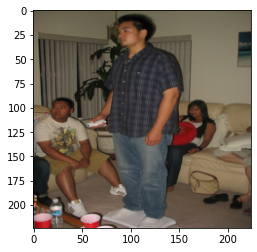

In [173]:
inputs, classes = next(iter(dataloader))
inputs = inputs[2]
inp = inputs
print(inp.shape)
inp = inp.numpy().transpose((1, 2, 0))
print(inp.shape, inputs.shape)
ci = (inp * 255).astype(np.uint8)
plt.imshow(ci)

In [181]:
classes

['Dark', 'Light']

In [182]:
class_names

{1: 'Dark', 0: 'Light'}

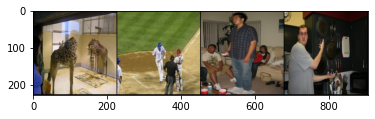

In [184]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = (inp * 255).astype(np.uint8)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [188]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j].item()]} | Label:{labels.cpu().data[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([0., 0., 1., 0.], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')


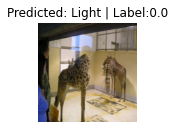

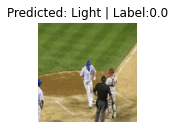

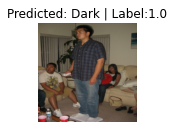

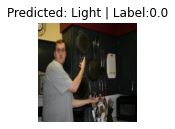

In [189]:
visualize_model(model_ft_n)

## Bias Mitigation

In [190]:
# Importing required Libraries
!pip install pytorch_revgrad
from pytorch_revgrad import RevGrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [191]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Setting Device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [193]:
resnet = models.resnet18(pretrained=True)

# Driver Code to freeze Resnet Layers
# for param in resnet.parameters():
#   param.requires_grad = False

### Bias Mitigation with Single Adversary

Bias mitigation with an adverserial branch (predicting racial cues) at the penultimate layer and a task-specific predictor as well. We minimze the task loss and maximize the critic loss. 

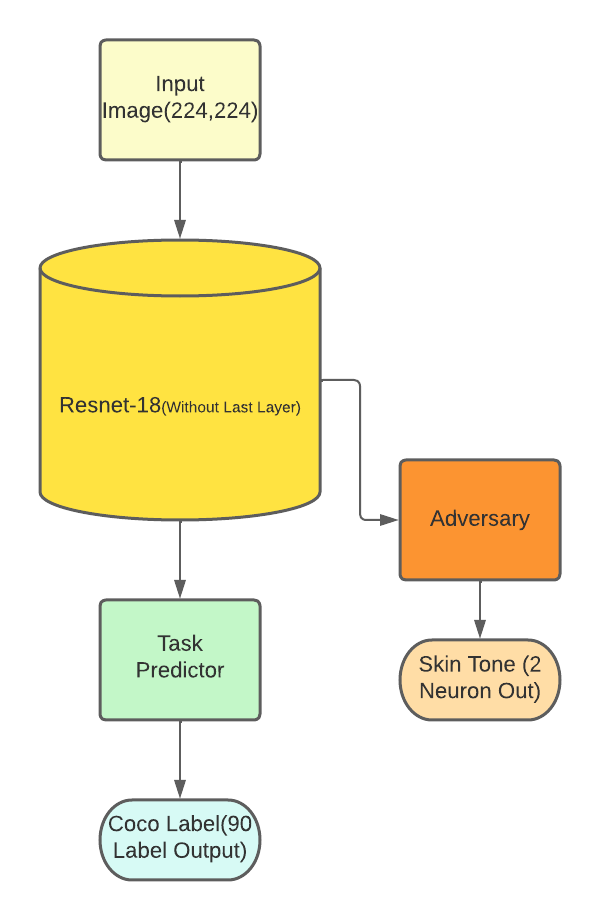



In [195]:
class BM(nn.Module):
    def __init__(self, resnet):
        super(BM,self).__init__()

        self.resnet = resnet

        self.branchadv = nn.Sequential(nn.Flatten(),
                        nn.Dropout(0.1),
                         nn.Linear(512, 64),
                         nn.Linear(64,2),
                         RevGrad())

        
        self.branchtask = nn.Sequential(nn.Flatten(),
                         nn.Dropout(0.1),
                         nn.Linear(512, 256),
                         nn.Linear(256, 91))


 
    def forward(self,x):
        x = self.resnet(x)
        adv = self.branchadv(x)
        task = self.branchtask(x)
        return adv, task


res_ft = torch.nn.Sequential(*(list(resnet.children())[:-1]))
modelbm = BM(res_ft)
modelbm.to(device)

BM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [197]:
# Using torchsummary to get a summary of input/output shapes, layers and output shapes
from torchsummary import summary
modelbm.to(device)
summary(modelbm,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [198]:
modelbm.branchadv

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=512, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=2, bias=True)
  (4): RevGrad()
)

In [199]:
# Defining dataset for the adove model

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class BmDataset(Dataset):
    def __init__(self, data, target1, target2, transform=None):
        self.data = data
        self.target1 = torch.Tensor(target1)
        self.target2 = torch.Tensor(target2)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y1 = self.target1[index]
        y2 = self.target2[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index],'RGB')
            x = self.transform(x)
        
        return x, y1, y2
    
    def __len__(self):
        return len(self.data)

data = img_arr_rn
yc = np.array(Ydual_pred)
target1 = yc
target2 = y_arr
datasetbm = BmDataset(data, target1, target2, transform=tr)
dataloaderbm = DataLoader(datasetbm, batch_size=4)

In [201]:
# Checking dataloader shapes

for x,y1,y2 in dataloaderbm:
  print(x.shape,y1.shape,y2.shape)
  break

torch.Size([4, 3, 224, 224]) torch.Size([4]) torch.Size([4])


In [203]:
# Checking output shapes
out1, out2 = modelbm(torch.randn(4,3,224,224).to(device))
print(out1.shape,out2.shape)

torch.Size([4, 2]) torch.Size([4, 91])


In [204]:
# Defininf training loop

criterion_bm = nn.CrossEntropyLoss()
optimizer_bm = torch.optim.Adam(filter(lambda p: p.requires_grad, modelbm.parameters()), lr=3e-6)
ds = len(datasetbm)

def train_bm(model, criterion, opt, dataloader, lamda, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, label1, label2 in dataloader:
            inputs = inputs.to(device)

            label1 = label1.type(torch.LongTensor)
            label1 = label1.to(device)

            label2 = label2.type(torch.LongTensor)
            label2 = label2.to(device)


            # zero the parameter gradients
            opt.zero_grad()

            # forward
            out_adv, out_task = modelbm(inputs)
            loss_task = criterion(out_task, label1)
            loss_adv = criterion(out_adv, label2)

            # backward + optimize only if in training phase
            # print(loss_adv,loss_task)

            loss = loss_task - lamda*loss_adv
            #loss = loss_adv

            loss.backward()
            opt.step()

            # statistics
            _, preds = torch.max(out_task, 1)
            # print("Predictions:",preds)
            # print("Labels:",label1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == label1.data)

        epoch_loss = running_loss / ds
        epoch_acc = running_corrects.double() / ds

        print(f'Train Loss: {epoch_loss:.4f}')    
        print(f'Train Accuracy: {epoch_acc:.4f}')  
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [205]:
model_bm_trained = train_bm(modelbm, criterion_bm, optimizer_bm, dataloaderbm, 0.5, num_epochs=50)

Epoch 0/49
----------
Train Loss: 4.0722
Train Accuracy: 0.1470

Epoch 1/49
----------
Train Loss: 3.4842
Train Accuracy: 0.3570

Epoch 2/49
----------
Train Loss: 3.1012
Train Accuracy: 0.3580

Epoch 3/49
----------
Train Loss: 2.8869
Train Accuracy: 0.3580

Epoch 4/49
----------
Train Loss: 2.7458
Train Accuracy: 0.3580

Epoch 5/49
----------
Train Loss: 2.6135
Train Accuracy: 0.3580

Epoch 6/49
----------
Train Loss: 2.4920
Train Accuracy: 0.3580

Epoch 7/49
----------
Train Loss: 2.3821
Train Accuracy: 0.3590

Epoch 8/49
----------
Train Loss: 2.2890
Train Accuracy: 0.3610

Epoch 9/49
----------
Train Loss: 2.1944
Train Accuracy: 0.3750

Epoch 10/49
----------
Train Loss: 2.1096
Train Accuracy: 0.3830

Epoch 11/49
----------
Train Loss: 2.0308
Train Accuracy: 0.3990

Epoch 12/49
----------
Train Loss: 1.9539
Train Accuracy: 0.4160

Epoch 13/49
----------
Train Loss: 1.8702
Train Accuracy: 0.4510

Epoch 14/49
----------
Train Loss: 1.8004
Train Accuracy: 0.4810

Epoch 15/49
--------

In [206]:
model_bm_trained.branchtask[2]

Linear(in_features=512, out_features=256, bias=True)

In [207]:
# Calculating dataset leakage for the model above
activation_onlymb = {}

dataloader_modelleakage_mb = DataLoader(datasetbm, batch_size=64)

def get_activation_mb(name):
    def hook(model, input, output):
        #print(model)
        activation_onlymb[name] = output.detach()
    return hook


modelmb = model_bm_trained

modelmb = modelmb.to(device)
modelmb.branchtask[2].register_forward_hook(get_activation_mb('fmb'))

xmb = next(iter(dataloader_modelleakage_mb))
xmb = xmb[0]
xmb = xmb.to(device)
mb_y = xmb[1]
output_mb = modelmb(xmb)
print(output_mb)

(tensor([[-0.0243, -0.6225],
        [ 0.2447, -0.6525],
        [ 0.0312, -0.1244],
        [-0.2435, -0.0187],
        [-0.1693, -0.1397],
        [ 0.1791, -0.1286],
        [ 0.3512, -0.2408],
        [-0.3552, -0.2497],
        [ 0.6671, -0.3357],
        [-0.5298, -0.3294],
        [-0.1038, -0.4162],
        [-0.2502, -0.3177],
        [-0.0211, -0.6216],
        [-0.4483, -0.3148],
        [ 0.0672, -0.5861],
        [ 0.1625, -0.3181],
        [-0.0771, -0.2445],
        [ 0.1489, -0.2307],
        [-0.4001, -0.2207],
        [-0.2386, -0.3951],
        [-0.1101, -0.3848],
        [ 0.2501, -0.3595],
        [ 0.0297, -0.7074],
        [ 0.0969, -0.8430],
        [-0.2157,  0.0281],
        [ 0.1322, -0.4526],
        [ 0.4461, -0.0219],
        [-0.4518, -0.7737],
        [-0.0937, -0.3400],
        [-0.0822,  0.1145],
        [-0.3062, -0.5915],
        [-0.7088, -0.4851],
        [ 0.2206, -0.0668],
        [-0.2314, -0.1371],
        [-0.3654, -0.1316],
        [-0.0059, -

In [208]:
activation_onlymb['fmb'].shape

torch.Size([64, 256])

In [209]:
tensor_x_bm = activation_onlymb['fmb']
tensor_y_bm = torch.tensor(y_arr)[:64]
print(tensor_x_bm.shape)
print(tensor_y_bm.shape)
tensor_y_bm = tensor_y_bm.type(torch.FloatTensor)

dsmb = TensorDataset(tensor_x_bm,tensor_y_bm) # creating dataset
dlmb  = DataLoader(dsmb, batch_size=2) # creating dataloader



loss_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
correct = 0

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    c = train(dlmb, model, loss_f, optim)
    accuracy = 100 * c / len(stdatasetml_atv)
    print("Accuracy is:",accuracy)
print("Done!")

torch.Size([64, 256])
torch.Size([64])
Epoch 1
-------------------------------
loss: 0.185373  [    0/   32]
Accuracy is: 90.625
Epoch 2
-------------------------------
loss: 0.185128  [    0/   32]
Accuracy is: 90.625
Epoch 3
-------------------------------
loss: 0.184884  [    0/   32]
Accuracy is: 90.625
Epoch 4
-------------------------------
loss: 0.184641  [    0/   32]
Accuracy is: 90.625
Epoch 5
-------------------------------
loss: 0.184398  [    0/   32]
Accuracy is: 90.625
Epoch 6
-------------------------------
loss: 0.184157  [    0/   32]
Accuracy is: 90.625
Epoch 7
-------------------------------
loss: 0.183917  [    0/   32]
Accuracy is: 90.625
Epoch 8
-------------------------------
loss: 0.183677  [    0/   32]
Accuracy is: 90.625
Epoch 9
-------------------------------
loss: 0.183438  [    0/   32]
Accuracy is: 90.625
Epoch 10
-------------------------------
loss: 0.183201  [    0/   32]
Accuracy is: 90.625
Done!


In [210]:
res_ft[7][0].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [211]:
from torchsummary import summary
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)
resnet.to(device)
summary(resnet,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Bias Mitigation with multiple adversaries across multiple layers

Bias mitigation with a multiple adverserial branches at the penultimate layer, conv6 and conv11 and a task-specific predictor. The outputs from these branches are concatenated and a linear probe predicting skin tone as an adversarial branch is added. We minimze the task loss and maximize the concatenated critic loss. 

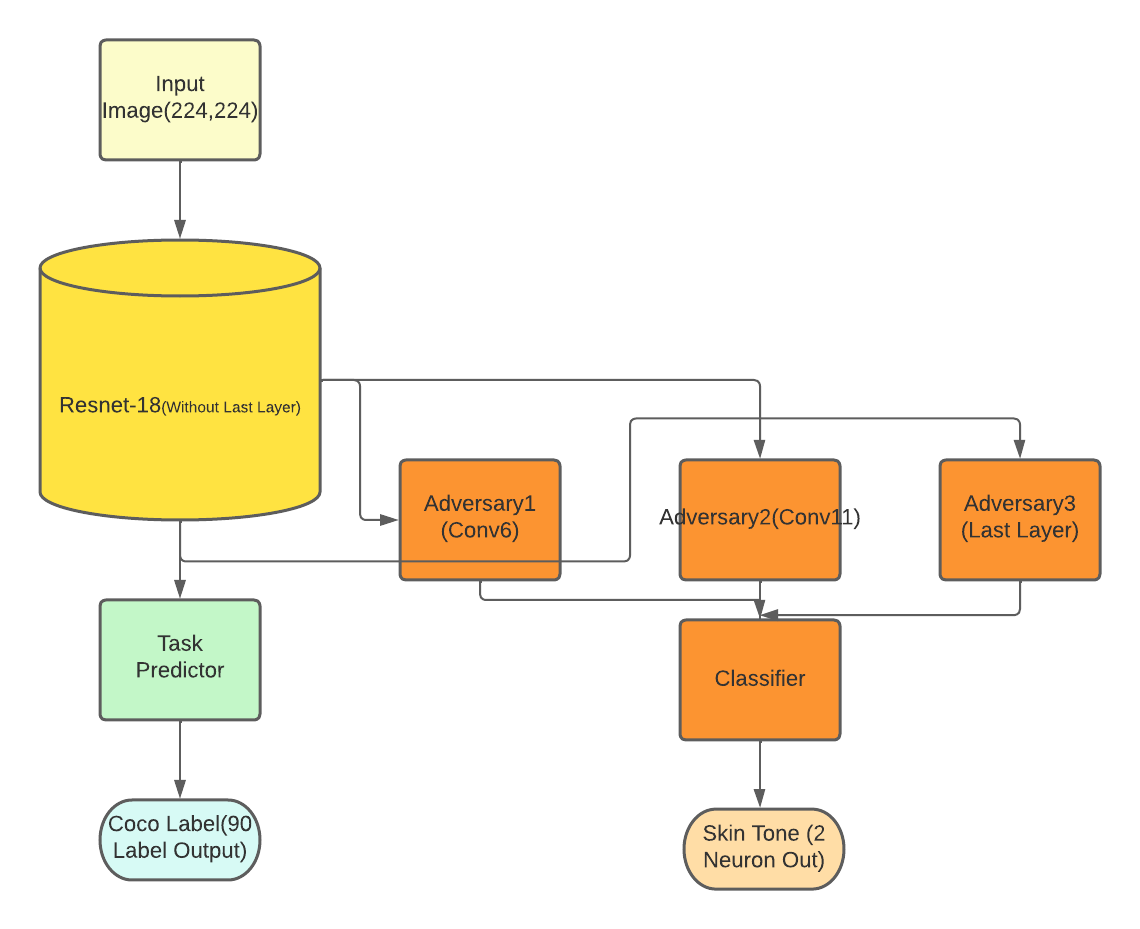

In [212]:
class BM_mc(nn.Module):
    def __init__(self):
        super(BM_mc,self).__init__()

        resnet = models.resnet18(pretrained=True)
        
        self.rp1 = torch.nn.Sequential(*(list(resnet.children())[0:5]))
        self.pool1 = nn.AdaptiveMaxPool2d((7,7))
        self.flat1 = nn.Flatten()
        self.drop1 = nn.Dropout(0.1)
        self.linad1 = nn.Linear(3136,512)
        self.linear1 = nn.Linear(512, 64)
        self.fin_adv1 = nn.Linear(64,32)
        self.revg1 = RevGrad()
    
        self.rp2 = torch.nn.Sequential(*(list(resnet.children())[5:6]))
        self.pool2 = nn.AdaptiveMaxPool2d((5,5))
        self.flat2 = nn.Flatten()
        self.drop2 = nn.Dropout(0.1)
        self.linear3 = nn.Linear(3200,1024)
        self.linear4 = nn.Linear(1024, 64)
        self.fin_adv2 = nn.Linear(64,32)
        self.revg2 = RevGrad()
        
        self.rp3 = torch.nn.Sequential(*(list(resnet.children())[6:7]))
        self.pool3 = nn.AdaptiveMaxPool2d((3,3))
        self.flat3 = nn.Flatten()
        self.drop3 = nn.Dropout(0.1)
        self.linear5 = nn.Linear(2304,512)
        self.linear6 = nn.Linear(512, 64)
        self.fin_adv3 = nn.Linear(64,32)
        self.revg3 = RevGrad()

        self.rp4 = torch.nn.Sequential(*(list(resnet.children())[7:9]))

        self.flat4 = nn.Flatten()
        self.drop4 = nn.Dropout(0.1)
        self.linear7 = nn.Linear(512, 256)
        self.task = nn.Linear(256, 91)

        self.fc1 = nn.Linear(96,12)
        self.fc2 = nn.Linear(12,2)


    def forward(self,x):
        x = self.rp1(x)

        x1 = self.pool1(x)
        x1 = self.flat1(x1)
        x1 = self.drop1(x1)
        x1 = self.linad1(x1)
        x1 = self.linear1(x1)
        x1 = self.fin_adv1(x1)
        x1 = self.revg1(x1)

        x = self.rp2(x)
        x2 = self.pool2(x)
        x2 = self.flat2(x2)
        x2 = self.drop2(x2)
        x2 = self.linear3(x2)
        x2 = self.linear4(x2)
        x2 = self.fin_adv2(x2)
        x2 = self.revg2(x2)

        x = self.rp3(x)
        x3 = self.pool3(x)
        x3 = self.flat3(x3)
        x3 = self.drop3(x3)
        x3 = self.linear5(x3)
        x3 = self.linear6(x3)
        x3 = self.fin_adv3(x3)
        x3 = self.revg3(x3)

        task = self.rp4(x)
        task = self.flat4(task)
        task = self.drop4(task)
        task = self.linear7(task)
        task = self.task(task)


        # x2 = self.revg(self.fin_adv(self.linear4(self.linear3(self.drop(self.flat(self.pool2(x)))))))
        # x3 = self.revg(self.fin_adv(self.linear1(self.linear5(self.drop(self.flat(self.pool3(x)))))))
        # task = self.task(self.linear6(self.drop(self.flatten(x))))
        
        adv = torch.cat((x1,x2,x3),1)
        adv = self.fc1(adv)
        adv = self.fc2(adv)
        
        return adv, task

modelbm_mc = BM_mc()
modelbm_mc.to(device)

BM_mc(
  (rp1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [213]:
# Checking outputs and output shapes
m = BM_mc().to(device)
O1, O2 = m(torch.randn(4,3,224,224).to(device))
print(O1.shape, O2.shape)

torch.Size([4, 2]) torch.Size([4, 91])


In [214]:
# Installing libraries to display model architecture using torchviz
!pip install torchviz
from graphviz import Digraph
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=b286a3a27da20dd24476c13b34e4663010a42417c1423ee9c02393071946dd4e
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


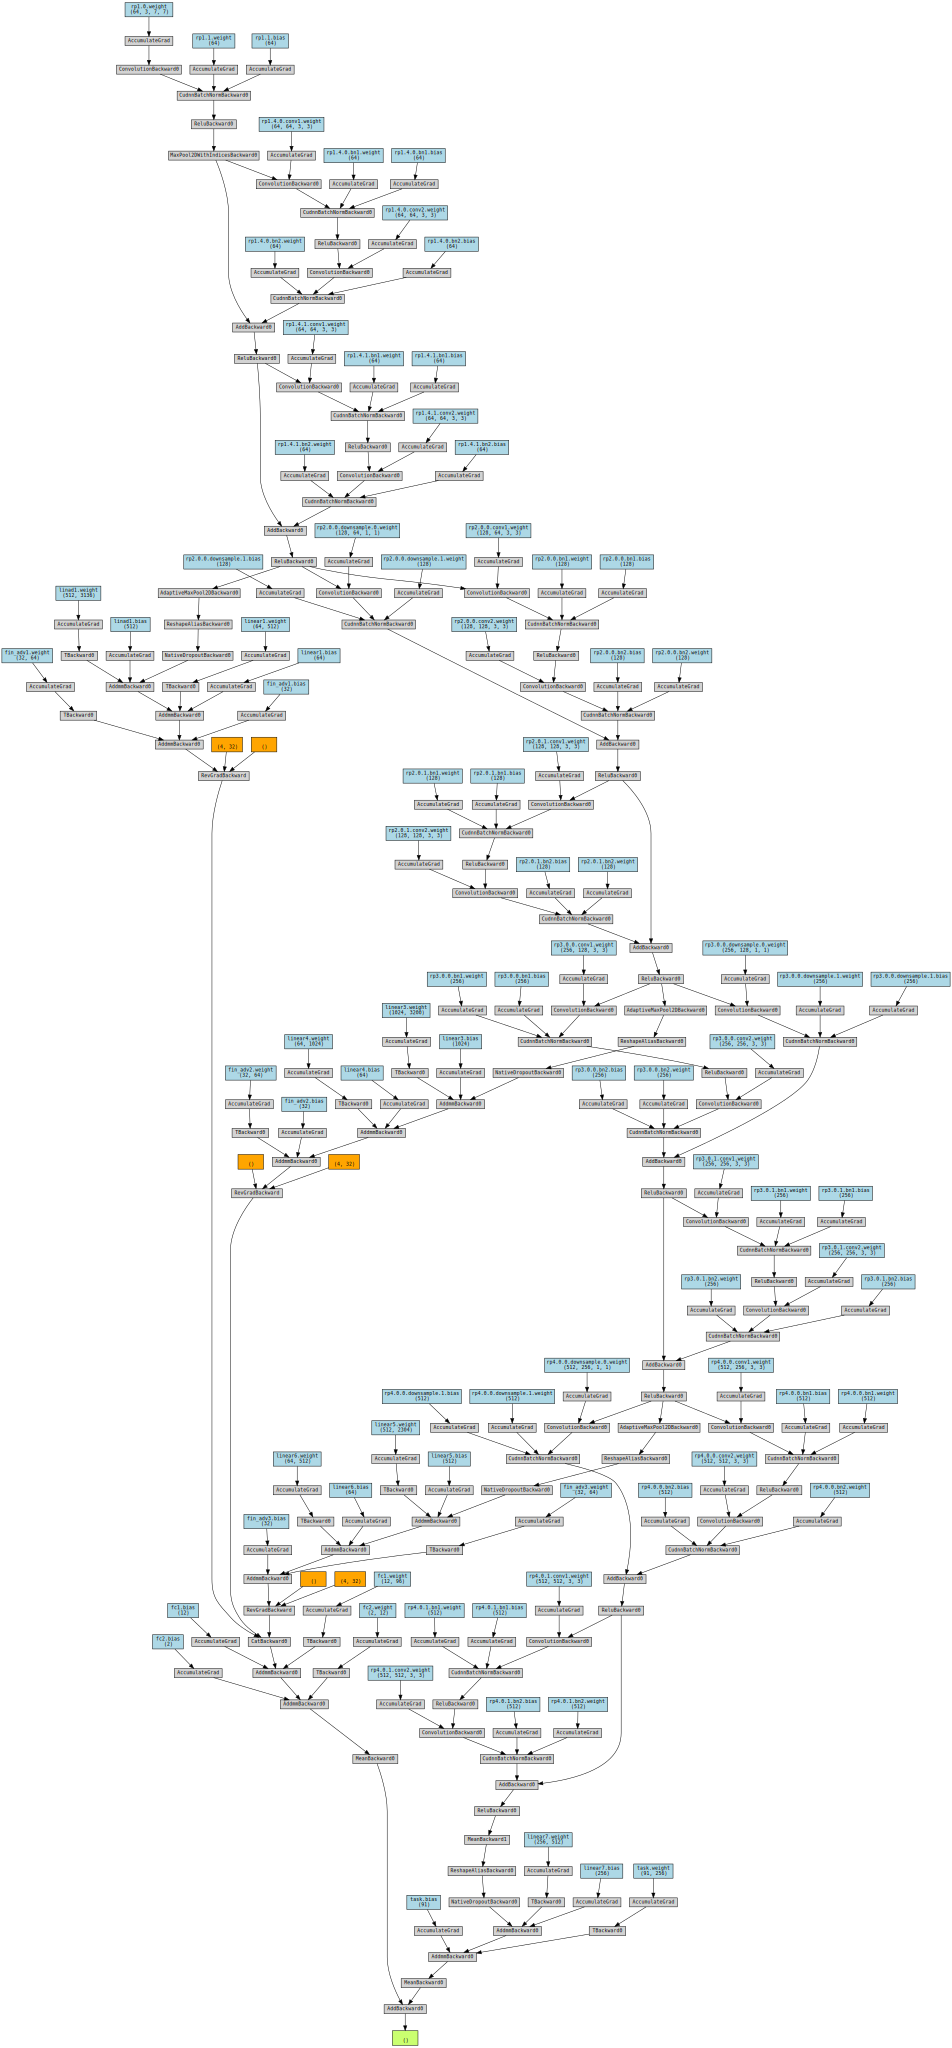

In [215]:
y = m(torch.randn(4,3,224,224).to(device))
make_dot(y[0].mean()+y[1].mean(), params=dict(m.named_parameters()))

In [216]:
from torchsummary import summary

modelbm_mc.to(device)
summary(modelbm_mc,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [217]:
# Experimenting with torch.cat
x = torch.randn(32)
print(x.shape)
v1 = torch.cat((x, x, x), 0)
# v2 = torch.cat((x, x, x), 1)
print(v1.shape)
# print(v2.shape)


torch.Size([32])
torch.Size([96])


In [218]:
# Defining training loop for the above model
criterion_bm = nn.CrossEntropyLoss()
optimizer_bm = torch.optim.Adam(filter(lambda p: p.requires_grad, modelbm_mc.parameters()), lr=3e-6)
ds = len(datasetbm)

def train_bm_mc(model, criterion, opt, dataloader, lamda, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, label1, label2 in dataloader:
            inputs = inputs.to(device)

            label1 = label1.type(torch.LongTensor)
            label1 = label1.to(device)

            label2 = label2.type(torch.LongTensor)
            label2 = label2.to(device)


            # zero the parameter gradients
            opt.zero_grad()

            # forward
            out_adv, out_task = model(inputs)
            loss_task = criterion(out_task, label1)
            loss_adv = criterion(out_adv, label2)

            # backward + optimize only if in training phase
            # print(loss_adv,loss_task)

            loss = loss_task - lamda*loss_adv
            #loss = loss_adv

            loss.backward()
            opt.step()

            # statistics
            _, preds = torch.max(out_task, 1)
            # print("Predictions:",preds)
            # print("Labels:",label1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == label1.data)

        epoch_loss = running_loss / ds
        epoch_acc = running_corrects.double() / ds

        print(f'Train Loss: {epoch_loss:.4f}')    
        print(f'Train Accuracy: {epoch_acc:.4f}')  
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [219]:
model_bm_mc_trained = train_bm_mc(modelbm_mc, criterion_bm, optimizer_bm, dataloaderbm, 0.5, num_epochs=50)

Epoch 0/49
----------
Train Loss: 4.0738
Train Accuracy: 0.1900

Epoch 1/49
----------
Train Loss: 3.5382
Train Accuracy: 0.3580

Epoch 2/49
----------
Train Loss: 3.1620
Train Accuracy: 0.3580

Epoch 3/49
----------
Train Loss: 2.9397
Train Accuracy: 0.3580

Epoch 4/49
----------
Train Loss: 2.7786
Train Accuracy: 0.3580

Epoch 5/49
----------
Train Loss: 2.6343
Train Accuracy: 0.3580

Epoch 6/49
----------
Train Loss: 2.5036
Train Accuracy: 0.3580

Epoch 7/49
----------
Train Loss: 2.3875
Train Accuracy: 0.3580

Epoch 8/49
----------
Train Loss: 2.2705
Train Accuracy: 0.3660

Epoch 9/49
----------
Train Loss: 2.1759
Train Accuracy: 0.3840

Epoch 10/49
----------
Train Loss: 2.0768
Train Accuracy: 0.3990

Epoch 11/49
----------
Train Loss: 1.9966
Train Accuracy: 0.4190

Epoch 12/49
----------
Train Loss: 1.9043
Train Accuracy: 0.4470

Epoch 13/49
----------
Train Loss: 1.8335
Train Accuracy: 0.4840

Epoch 14/49
----------
Train Loss: 1.7605
Train Accuracy: 0.4990

Epoch 15/49
--------

In [220]:
batch = next(iter(dataloaderbm))

In [264]:
model_bm_mc_trained.linear7

Linear(in_features=512, out_features=256, bias=True)

In [265]:
# Calculating Dataset Leakage for the above model

activation_bm_mc = {}
dataloader_modelleakage_bmmc = DataLoader(datasetbm, batch_size=64)

def get_activation_ae(name):
    def hook(model, input, output):
        activation_bm_mc[name] = output.detach()
    return hook

modelbmmb = model_bm_mc_trained

modelbmmc = modelbmmb.to(device)
modelbmmc.drop4.register_forward_hook(get_activation_ae('fmc'))

bmc_m = next(iter(dataloader_modelleakage_bmmc))
bmc_m = bmc_m[0]
bmc_m = bmc_m.to(device)
mb_y = bmc_m[1]
output_bm_mc = modelbmmc(bmc_m)
print(output_bm_mc)

(tensor([[-0.5531,  0.2060],
        [-0.4624,  0.2176],
        [-0.5722,  0.1962],
        [-0.5633,  0.1221],
        [-0.5650,  0.1100],
        [-0.5284,  0.1490],
        [-0.6382,  0.1126],
        [-0.5948,  0.1060],
        [-0.4964,  0.1713],
        [-0.5101,  0.1236],
        [-0.4979,  0.1440],
        [-0.5482,  0.1562],
        [-0.5237,  0.1411],
        [-0.4883,  0.1824],
        [-0.6368,  0.1682],
        [-0.5295,  0.1109],
        [-0.4331,  0.1359],
        [-0.5422,  0.1253],
        [-0.5737,  0.1408],
        [-0.5235,  0.1060],
        [-0.5813,  0.1496],
        [-0.6374,  0.1357],
        [-0.4599,  0.1078],
        [-0.5284,  0.0920],
        [-0.5369,  0.1146],
        [-0.6374,  0.1447],
        [-0.5934,  0.1028],
        [-0.5310,  0.1705],
        [-0.5368,  0.2142],
        [-0.5228,  0.1687],
        [-0.5733,  0.1134],
        [-0.5759,  0.1575],
        [-0.5711,  0.1509],
        [-0.5875,  0.0998],
        [-0.4669,  0.1803],
        [-0.4923,  

In [266]:
activation_bm_mc['fmc'].shape

torch.Size([64, 91])

In [268]:
tensor_x_bmmc = activation_bm_mc['fmc']
tensor_y_bmmc = torch.tensor(y_arr)[:64]
print(tensor_x_bmmc.shape)
print(tensor_y_bmmc.shape)
tensor_y_bmmc = tensor_y_bmmc.type(torch.FloatTensor)

dsam = TensorDataset(tensor_x_bmmc,tensor_y_bmmc) # create your datset
dlam = DataLoader(dsam, batch_size=2) # create your dataloader


loss_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
correct = 0

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    c = train(dlam, model1, loss_f, optim)
    accuracy = 100 * c / len(dsam)
    print("Accuracy is:",accuracy)
print("Done!")

torch.Size([64, 91])
torch.Size([64])
Epoch 1
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 2
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 3
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 4
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 5
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 6
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 7
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 8
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 9
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Epoch 10
-------------------------------
loss: 0.638340  [    0/   32]
Accuracy is: 90.625
Done!


### Bias Mitigation with an AutoEncoder Layer

I add a convolutional auto-encoder model at the first layer. The input image is first passed through an encoder followed by a bottleneck layer of size 128x1x1 and then through a decoder to the Resnet-18 block. I create a classifier branch from the bottleneck layer and concatenate these extracted features to the adversarial branch at the adaptive pooling layer. 
Finally, I add a classifier to predict skin colour from representations of the bottleneck layer and the last Resnet-18 layer. I also have a task-specific predictor at the penultimate layer so that the critic loss is maximized while minimising the task loss. 
I hypothesize that suppressing feature correlations from the bottleneck layer will suppress features that contribute to skin tone prediction indirectly. 
I reason that hiding these features in the bottleneck layer will result in the reconstructed image at the decoder lacking skin tones cues.
Thus lack of these features will make it difficult to predict skin colour from these reconstructed images. 
Further our adversarial branch will help in eliminating the remaining existing features.

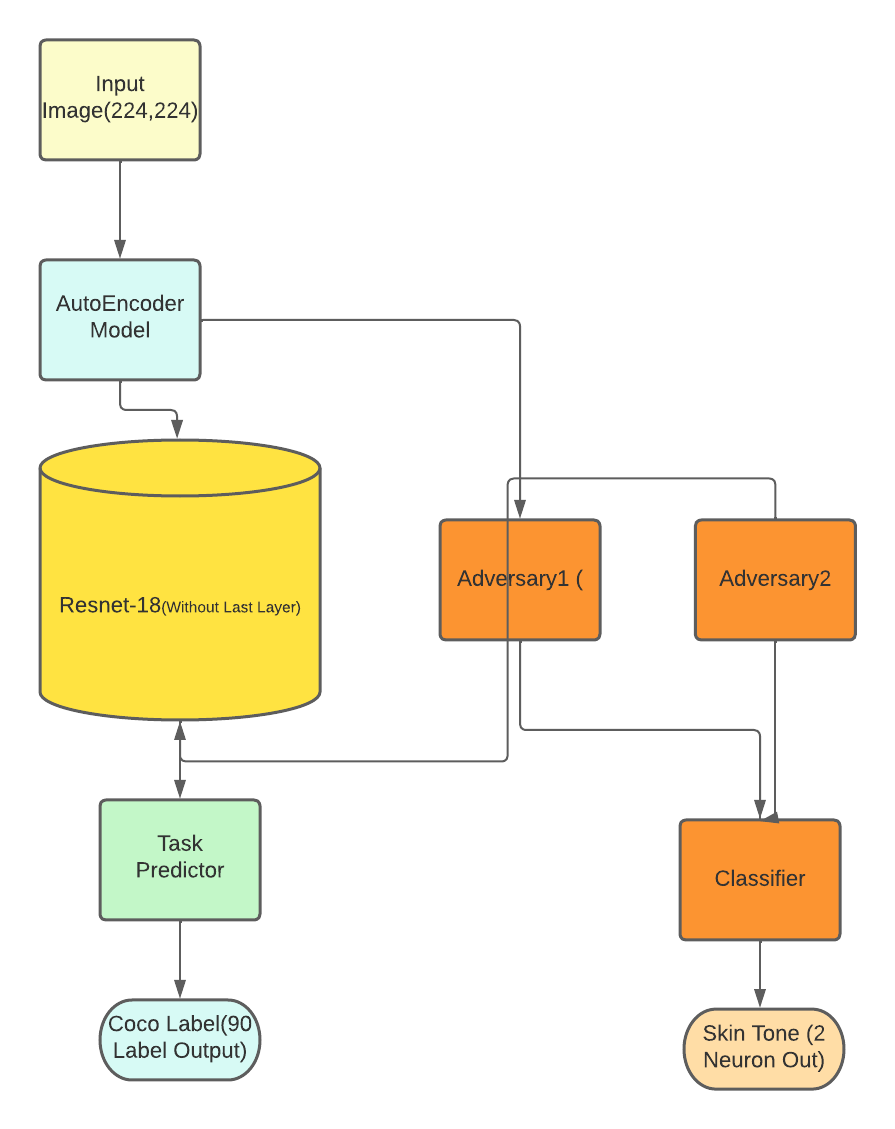



In [222]:
# Defining the model, dataloader and training loop below
class BM_ae(nn.Module):
    def __init__(self, resnet):
        super(BM_ae,self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # -> N, 16, 112, 112
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # -> N, 16, 56, 56
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 28, 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # -> N, 32, 14, 14
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> N, 64, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 7) # -> N, 128, 1, 1
        )

        self.flat1 = nn.Flatten()
        self.drop1 = nn.Dropout(0.1)
        self.lin1 = nn.Linear(128, 64)
        self.lin2 = nn.Linear(64,32)
        self.rg1 = RevGrad()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7), # -> N, 64, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 32, 14, 14 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), # N, 32, 28, 28 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 56, 56 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 112, 112 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # N, 3, 224, 224 
            nn.Sigmoid()
        )

        self.flat2 = nn.Flatten()
        self.drop2 = nn.Dropout(0.1)
        self.lin3 = nn.Linear(512, 64)
        self.lin4 = nn.Linear(64,32)
        self.rg2 = RevGrad()

        self.resnet = resnet

        
        self.branchtask = nn.Sequential(nn.Flatten(),
                         nn.Dropout(0.1),
                         nn.Linear(512, 256),
                         nn.Linear(256, 91))
        
        self.fc1 = nn.Linear(64,16)
        self.fc2 = nn.Linear(16,2)

 
    def forward(self,x):
        xe = self.encoder(x)

        x1 = self.flat1(xe)
        x1 = self.drop1(x1) 
        x1 = self.lin1(x1) 
        x1 = self.lin2(x1)
        x1 = self.rg1(x1)

        xd = self.decoder(xe)

        xr = self.resnet(xd)

        x2 = self.flat2(xr)
        x2 = self.drop2(x2)
        x2 = self.lin3(x2)
        x2 = self.lin4(x2)
        x2 = self.rg2(x2)

        task = self.branchtask(xr)

        adv = torch.cat((x1,x2),1)
        adv = self.fc1(adv)
        adv = self.fc2(adv)

        return adv, task


res_ft = torch.nn.Sequential(*(list(resnet.children())[:-1]))
modelbm_ae = BM_ae(res_ft)
modelbm_ae.to(device)

BM_ae(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  )
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.1, inplace=False)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (rg1): RevGrad()
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    

In [223]:
from torchsummary import summary
# m  = models.resnet18(pretrained=True)
modelbm_ae.to(device)
summary(modelbm_ae,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
              ReLU-2         [-1, 16, 112, 112]               0
         MaxPool2d-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7             [-1, 64, 7, 7]          18,496
              ReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 1, 1]         401,536
          Flatten-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
           Linear-13                   [-1, 32]           2,080
          RevGrad-14                   

In [224]:
criterion_bm_ae = nn.CrossEntropyLoss()
optimizer_bm_ae = torch.optim.Adam(filter(lambda p: p.requires_grad, modelbm_ae.parameters()), lr=3e-6)
ds = len(datasetbm)

def train_bm_mc(model, criterion, opt, dataloader, lamda, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, label1, label2 in dataloader:
            inputs = inputs.to(device)

            label1 = label1.type(torch.LongTensor)
            label1 = label1.to(device)

            label2 = label2.type(torch.LongTensor)
            label2 = label2.to(device)


            # zero the parameter gradients
            opt.zero_grad()

            # forward
            out_adv, out_task = model(inputs)
            loss_task = criterion(out_task, label1)
            loss_adv = criterion(out_adv, label2)

            # backward + optimize only if in training phase
            # print(loss_adv,loss_task)

            loss = loss_task - lamda*loss_adv
            #loss = loss_adv

            loss.backward()
            opt.step()

            # statistics
            _, preds = torch.max(out_task, 1)
            # print("Predictions:",preds)
            # print("Labels:",label1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == label1.data)

        epoch_loss = running_loss / ds
        epoch_acc = running_corrects.double() / ds

        print(f'Train Loss: {epoch_loss:.4f}')    
        print(f'Train Accuracy: {epoch_acc:.4f}')  
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [225]:
model_bm_ae = train_bm_mc(modelbm_ae, criterion_bm_ae, optimizer_bm_ae, dataloaderbm, 0.6, num_epochs=100)

Epoch 0/99
----------
Train Loss: 3.7851
Train Accuracy: 0.2010

Epoch 1/99
----------
Train Loss: 3.2713
Train Accuracy: 0.3580

Epoch 2/99
----------
Train Loss: 3.0990
Train Accuracy: 0.3580

Epoch 3/99
----------
Train Loss: 3.0226
Train Accuracy: 0.3580

Epoch 4/99
----------
Train Loss: 2.9600
Train Accuracy: 0.3580

Epoch 5/99
----------
Train Loss: 2.9102
Train Accuracy: 0.3580

Epoch 6/99
----------
Train Loss: 2.8760
Train Accuracy: 0.3580

Epoch 7/99
----------
Train Loss: 2.8441
Train Accuracy: 0.3580

Epoch 8/99
----------
Train Loss: 2.8163
Train Accuracy: 0.3580

Epoch 9/99
----------
Train Loss: 2.7947
Train Accuracy: 0.3580

Epoch 10/99
----------
Train Loss: 2.7807
Train Accuracy: 0.3580

Epoch 11/99
----------
Train Loss: 2.7607
Train Accuracy: 0.3580

Epoch 12/99
----------
Train Loss: 2.7399
Train Accuracy: 0.3580

Epoch 13/99
----------
Train Loss: 2.7258
Train Accuracy: 0.3580

Epoch 14/99
----------
Train Loss: 2.7151
Train Accuracy: 0.3580

Epoch 15/99
--------

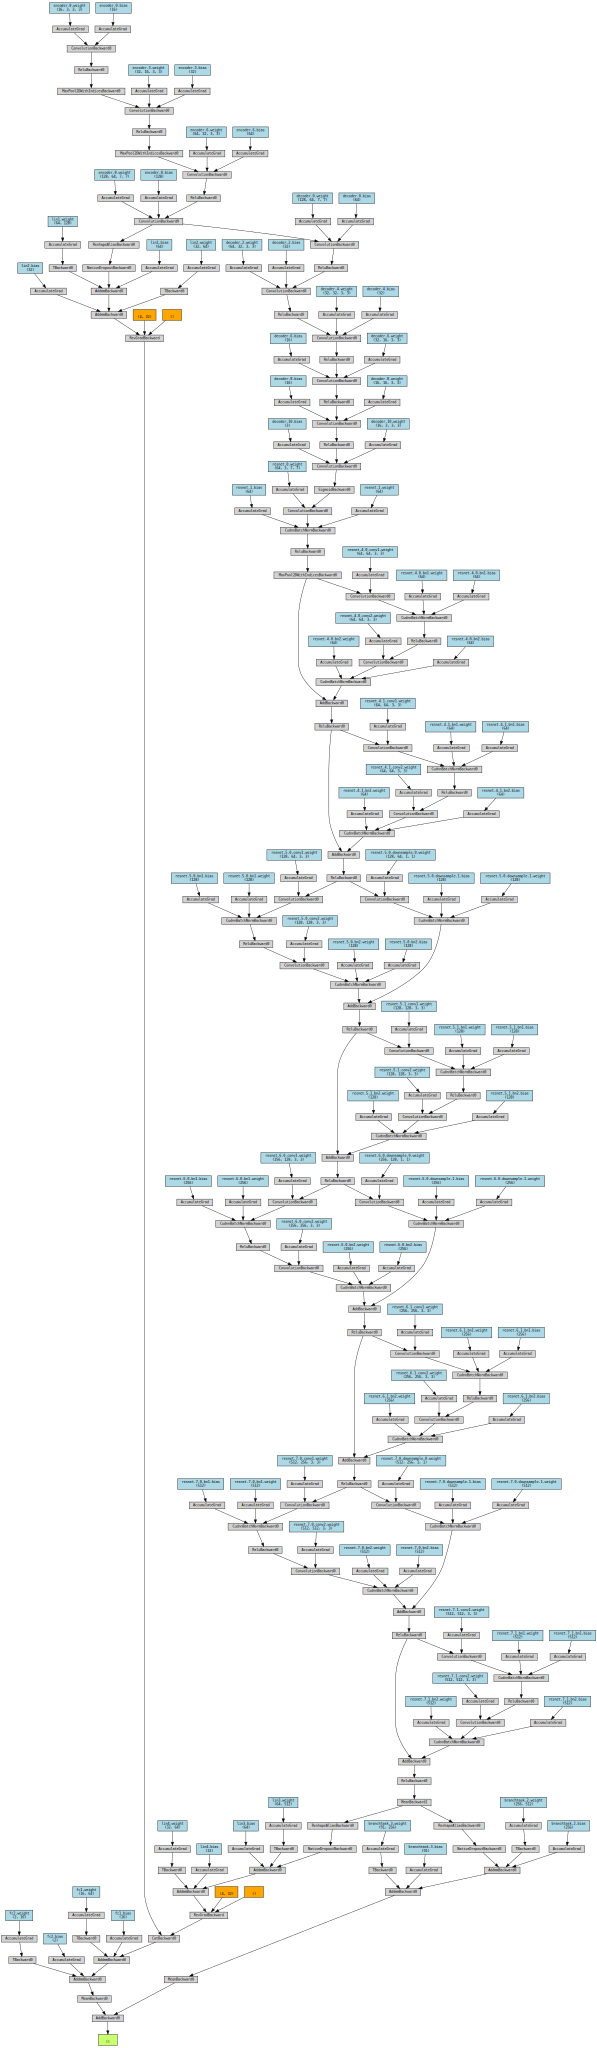

In [226]:
# Using torchviz to display the mode arch
y = model_bm_ae(torch.randn(4,3,224,224).to(device))
make_dot(y[0].mean()+y[1].mean(), params=dict(model_bm_ae.named_parameters()))

In [230]:
# Calculating dataset leakage for the model above

In [232]:
activation_onlyae = {}
dataloader_modelleakage_ae = DataLoader(datasetbm, batch_size=64)

def get_activation_ae(name):
    def hook(model, input, output):
        #print(model)
        activation_onlyae[name] = output.detach()
    return hook


modelae = model_bm_ae

modelae = modelae.to(device)
modelae.branchtask[2].register_forward_hook(get_activation_ae('fae'))

xmb = next(iter(dataloader_modelleakage_mb))
xmb = xmb[0]
xmb = xmb.to(device)
mb_y = xmb[1]
output_ae = modelae(xmb)
print(output_ae)

(tensor([[ 0.1185, -0.0929],
        [ 0.1111, -0.0549],
        [ 0.0816, -0.0942],
        [ 0.1245, -0.0571],
        [ 0.1147, -0.0506],
        [ 0.1171, -0.0044],
        [ 0.1226, -0.0581],
        [ 0.1266, -0.0771],
        [ 0.1038, -0.0753],
        [ 0.0945, -0.0413],
        [ 0.1046, -0.0900],
        [ 0.1212, -0.0674],
        [ 0.0818, -0.0321],
        [ 0.1080, -0.0699],
        [ 0.0708, -0.1038],
        [ 0.0987, -0.0837],
        [ 0.0880, -0.1220],
        [ 0.1048, -0.1401],
        [ 0.1026, -0.0659],
        [ 0.1116, -0.0744],
        [ 0.1307, -0.0400],
        [ 0.1175, -0.0707],
        [ 0.0980, -0.0537],
        [ 0.0908, -0.0831],
        [ 0.1121, -0.0777],
        [ 0.1091, -0.0754],
        [ 0.1295, -0.0325],
        [ 0.0826, -0.1120],
        [ 0.1063, -0.0973],
        [ 0.0958, -0.0460],
        [ 0.1001, -0.0374],
        [ 0.0898, -0.0705],
        [ 0.1177, -0.0464],
        [ 0.1287, -0.0780],
        [ 0.0940, -0.0932],
        [ 0.1117, -

In [233]:
activation_onlyae['fae'].shape

torch.Size([64, 256])

In [234]:
tensor_x_AE = activation_onlyae['fae']
tensor_y_AE = torch.tensor(y_arr)[:64]
print(tensor_x_AE.shape)
print(tensor_y_AE.shape)
tensor_y_AE = tensor_y_AE.type(torch.FloatTensor)

dsae = TensorDataset(tensor_x_AE,tensor_y_AE) # create your datset
dlae = DataLoader(dsae, batch_size=2) # create your dataloader


loss_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
correct = 0

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    c = train(dlae, model, loss_f, optim)
    accuracy = 100 * c / len(dsae)
    print("Accuracy is:",accuracy)
print("Done!")


torch.Size([64, 256])
torch.Size([64])
Epoch 1
-------------------------------
loss: 0.182965  [    0/   32]
Accuracy is: 90.625
Epoch 2
-------------------------------
loss: 0.182730  [    0/   32]
Accuracy is: 90.625
Epoch 3
-------------------------------
loss: 0.182495  [    0/   32]
Accuracy is: 90.625
Epoch 4
-------------------------------
loss: 0.182262  [    0/   32]
Accuracy is: 90.625
Epoch 5
-------------------------------
loss: 0.182029  [    0/   32]
Accuracy is: 90.625
Epoch 6
-------------------------------
loss: 0.181797  [    0/   32]
Accuracy is: 90.625
Epoch 7
-------------------------------
loss: 0.181567  [    0/   32]
Accuracy is: 90.625
Epoch 8
-------------------------------
loss: 0.181336  [    0/   32]
Accuracy is: 90.625
Epoch 9
-------------------------------
loss: 0.181107  [    0/   32]
Accuracy is: 90.625
Epoch 10
-------------------------------
loss: 0.180879  [    0/   32]
Accuracy is: 90.625
Done!


### The End.

***Thank you!***